# PHA Data

https://fermi.gsfc.nasa.gov/ssc/data/analysis/gbm/gbm_data_tools/gdt-docs/notebooks/Simulations.html

In [1]:
from gbm import test_data_dir
from gbm.data import TTE, RSP
from gbm.binning.unbinned import bin_by_time

# open a TTE file and response
tte = TTE.open(test_data_dir+'/glg_tte_n9_bn090131090_v00.fit')
rsp = RSP.open(test_data_dir+'/glg_cspec_n9_bn090131090_v00.rsp2')

# bin to 1.024 s resolution, reference time is trigger time
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)

In [2]:
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial

bkgd_times = [(-20.0, -5.0), (75.0, 200.0)]
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)

backfitter.fit(order=1)
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)

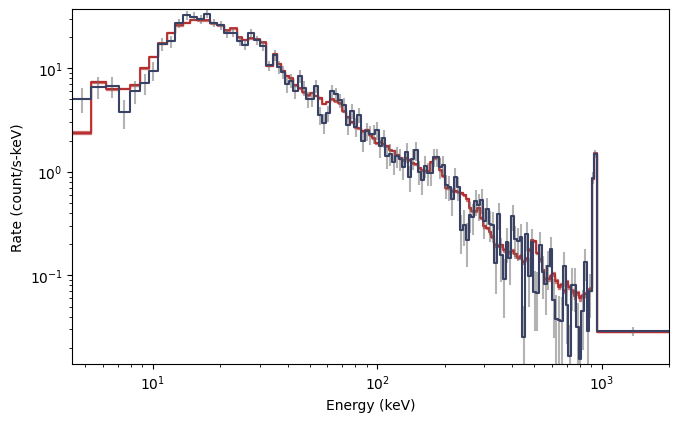

In [3]:
%matplotlib inline
from gbm.plot import Lightcurve, Spectrum

select_time = (150.0, 152.0)

# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*select_time)  # <-- This is what we will use for our simulations

# and the data
spec_data = phaii.to_spectrum(time_range=select_time)

# plot the comparison between the background model and the data
specplot = Spectrum(data=spec_data, background=spec_bkgd)

In [4]:
# Band function with amplitude=0.1, Epeak=300 keV, alpha=-1.0, beta=-2.5
from gbm.spectra.functions import Band
band_params = (0.1, 300.0, -1.0, -2.5)

# 2 s exposure
exposure = 2.0

In [5]:
from gbm.simulate import PhaSimulator
pha_sims = PhaSimulator(rsp, Band(), band_params, exposure, spec_bkgd, 'Gaussian')

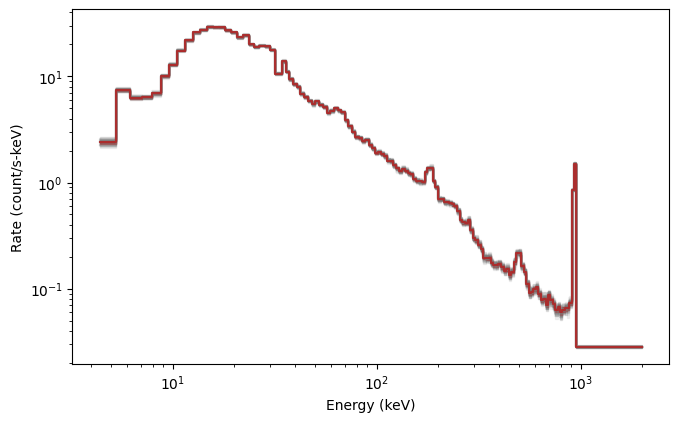

In [6]:
# make 20 simulations of the background
bkgd_devs = pha_sims.simulate_background(20)


# And plot the background model and 20 simulations
# SpectrumBackground is the plotting class for spectral background models
from gbm.plot.gbmplot import SpectrumBackground

specplot = Spectrum()
# background from each simulation
sim_bkgds = [SpectrumBackground(bkgd_dev, specplot.ax, color='gray', alpha=0.1) for bkgd_dev in bkgd_devs]
# our original background model
specplot.set_background(spec_bkgd)

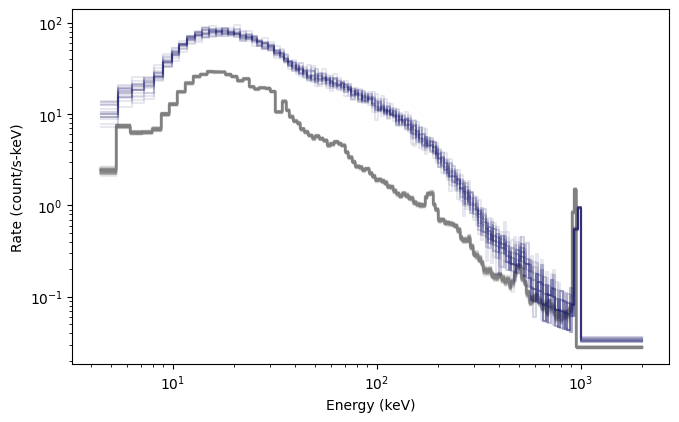

In [7]:
# 20 source+background simulations
summed_devs = pha_sims.simulate_sum(20)

# Histo is the plotting class for observed lightcurves or count spectra
from gbm.plot.gbmplot import Histo

specplot = Spectrum()
# background from each simulation
sim_bkgds = [SpectrumBackground(bkgd_dev, specplot.ax, color='gray', alpha=0.1) for bkgd_dev in bkgd_devs]
# the summed "observed" data from each simulation
sim_signals = [Histo(summed_dev, specplot.ax, color='midnightblue', alpha=0.1) for summed_dev in summed_devs]

In [9]:
# create 5 simulated BAK and PHA objects
baks = pha_sims.to_bak(5)
phas = pha_sims.to_pha(5)
print(baks)
print(phas)

[<gbm.data.pha.BAK object at 0x771486bb6c90>, <gbm.data.pha.BAK object at 0x771486b84d10>, <gbm.data.pha.BAK object at 0x771486b3bb90>, <gbm.data.pha.BAK object at 0x771486ed4b90>, <gbm.data.pha.BAK object at 0x771486ed4c90>]
[<gbm.data.pha.PHA object at 0x771487368e50>, <gbm.data.pha.PHA object at 0x771486f70810>, <gbm.data.pha.PHA object at 0x771483192a10>, <gbm.data.pha.PHA object at 0x771486addf50>, <gbm.data.pha.PHA object at 0x771486af4d50>]


In [10]:
# concatenate 10 simulations into a single PHAII object
pha_sims.to_phaii(10)

# TTE Data

In [11]:
# source and background simulators
from gbm.simulate import TteSourceSimulator, TteBackgroundSimulator

# A tophat (rectangular) pulse and a constant background
from gbm.simulate.profiles import tophat, constant

In [12]:
# amplitude, start and stop times of the tophat pulse
tophat_params = (0.05, 0.0, 2.0)

# initialize simulator with the spectral model and time profile
tte_sim = TteSourceSimulator(rsp, Band(), band_params, tophat, tophat_params)

# time range over which to simulate source
tte_src = tte_sim.to_tte(-5.0, 10.0)

In [13]:
# use our background model spectrum and scale to 200% of the background amplitude
constant_params = (2.0,)
tte_sim = TteBackgroundSimulator(spec_bkgd, 'Gaussian', constant, constant_params)

# time range over which to simulate background
tte_bkgd = tte_sim.to_tte(-10.0, 10.0)

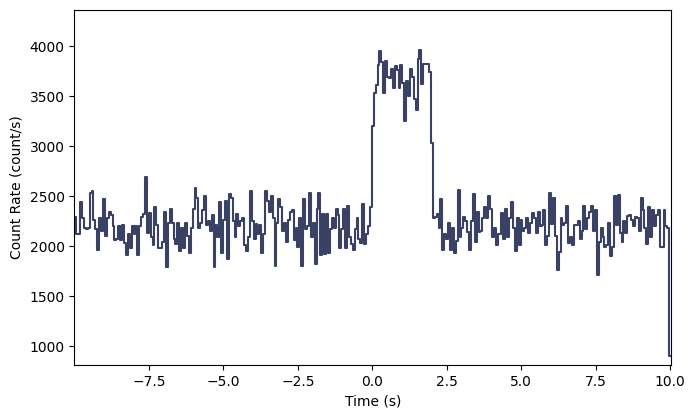

In [14]:
# merge the background and source
tte_total = TTE.merge([tte_bkgd, tte_src])

# bin to 64 ms resolution so we can make a lightcurve plot
phaii = tte_total.to_phaii(bin_by_time, 0.064)
lcplot = Lightcurve(data=phaii.to_lightcurve(energy_range=(8.0, 900.0)))
lcplot.errorbars.hide()

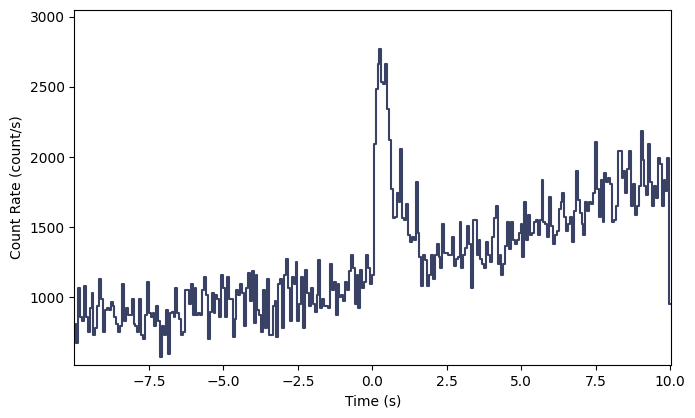

In [15]:
# a Norris pulse shape and a quadratic background
from gbm.simulate.profiles import norris, quadratic

norris_params = (0.05, 0.0, 0.1, 0.5)
quadratic_params = (1.0, 0.05, 0.003)

# source simulation
tte_sim = TteSourceSimulator(rsp, Band(), band_params, norris, norris_params)
tte_src = tte_sim.to_tte(-5.0, 10.0)

# background simulation
tte_sim = TteBackgroundSimulator(spec_bkgd, 'Gaussian', quadratic, quadratic_params)
tte_bkgd = tte_sim.to_tte(-10.0, 10.0)

# merge the background and source
tte_total = TTE.merge([tte_bkgd, tte_src])

# bin to 64 ms resolution so we can make a lightcurve plot
phaii = tte_total.to_phaii(bin_by_time, 0.064)
lcplot = Lightcurve(data=phaii.to_lightcurve(energy_range=(8.0, 900.0)))
lcplot.errorbars.hide()